In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from pathlib import Path

In [2]:
# Import engine to make connection to database

from sqlalchemy import create_engine

In [3]:
# Connect to Flights_DB

db_path = Path('Resources/Flights_DB.sqlite')
engine = create_engine(f'sqlite:///{db_path}')

conn = engine.connect()

In [4]:
# Load Flights table, join Cancelled_Flights and Delayed_Flights for reasons

flights_df = pd.read_sql_query('''
                                  SELECT F.Operating_Airline
                                      ,F.Origin_Airport
                                      ,F.Destination_Airport
                                      ,F.Flight_Date
                                      ,F.Scheduled_Arrival_Time
                                      ,F.Scheduled_Departure_Time
                                      ,D.Carrier_Delay_Minutes
                                      ,D.Weather_Delay_Minutes
                                      ,D.NAS_Delay_Minutes
                                      ,D.Security_Delay_Minutes
                                      ,D.Late_Aircraft_Delay_Minutes
                                      ,C.Cancellation_Code
                                      ,F.Target
                                  FROM Flights F
                                  LEFT JOIN Cancelled_Flights C ON F.ID = C.ID
                                  LEFT JOIN Delayed_Flights D ON F.ID = D.ID
                               ''',
                               con=engine,
                               dtype={
                                   'Operating_Airline': object,
                                   'Origin_Airport': object,
                                   'Destination_Airport': object,
                                   'Flight_Date': np.datetime64,
                                   'Scheduled_Arrival_Time': np.datetime64,
                                   'Scheduled_Departure_Time': np.datetime64,
                                   'Carrier_Delay_Minutes': object,
                                   'Weather_Delay_Minutes': object,
                                   'NAS_Delay_Minutes': object,
                                   'Security_Delay_Minutes': object,
                                   'Late_Aircraft_Delay_Minutes': object,
                                   'Cancellation_Code': object,
                                   'Target': np.int32
                               })

flights_df.head(10)

,Operating_Airline,Origin_Airport,Destination_Airport,Flight_Date,Scheduled_Arrival_Time,Scheduled_Departure_Time,Carrier_Delay_Minutes,Weather_Delay_Minutes,NAS_Delay_Minutes,Security_Delay_Minutes,Late_Aircraft_Delay_Minutes,Cancellation_Code,Target
0,DL,FLL,LGA,2022-01-06,2023-02-22 14:19:00,2023-02-22 11:26:00,None,None,None,None,None,A,2
1,DL,ATL,FLL,2022-01-06,2023-02-22 18:21:00,2023-02-22 16:31:00,None,None,None,None,None,None,0
2,DL,FLL,ATL,2022-01-06,2023-02-22 21:27:00,2023-02-22 19:31:00,None,None,None,None,None,None,0
3,DL,FLL,RDU,2022-01-06,2023-02-22 12:27:00,2023-02-22 10:24:00,None,None,None,None,None,None,0
4,DL,ATL,JAN,2022-01-06,2023-02-22 11:42:00,2023-02-22 11:17:00,None,None,None,None,None,None,0
5,DL,JAN,ATL,2022-01-06,2023-02-22 14:58:00,2023-02-22 12:37:00,None,None,None,None,None,None,0
6,DL,RIC,ATL,2022-01-06,2023-02-22 10:50:00,2023-02-22 09:00:00,None,None,None,None,None,None,0
7,DL,MSP,RSW,2022-01-06,2023-02-22 14:33:00,2023-02-22 10:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,None,1
8,DL,ATL,RDU,2022-01-06,2023-02-22 15:33:00,2023-02-22 14:14:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,None,1
9,DL,RDU,ATL,2022-01-06,2023-02-22 18:14:00,2023-02-22 16:43:00,None,None,None,None,None,None,0


In [6]:
# Get day from Flight_Date
flights_df['Day'] = flights_df['Flight_Date'].dt.day

In [15]:
# Group by Target then Day and count
count_by_day = flights_df.groupby(['Target', 'Day']).count()

In [16]:
count_by_day.head()

Operating_Airline  Origin_Airport  Destination_Airport  \
Target Day                                                           
0      1                67343           67343                67343   
       2                61153           61153                61153   
       3                63515           63515                63515   
       4                67007           67007                67007   
       5                62413           62413                62413   

            Flight_Date  Scheduled_Arrival_Time  Scheduled_Departure_Time  \
Target Day                                                                  
0      1          67343                   67343                     67343   
       2          61153                   61153                     61153   
       3          63515                   63515                     63515   
       4          67007                   67007                     67007   
       5          62413                   62413                     62413   

            Carrier_Delay_Minutes  Weather_Delay_Minutes  NAS_Delay_Minutes  \
Target Day                                                                    
0      1                        0                      0                  0   
       2                        0                      0                  0   
       3                        0                      0                  0   
       4                        0                      0                  0   
       5                        0                      0                  0   

            Security_Delay_Minutes  Late_Aircraft_Delay_Minutes  \
Target Day                                                        
0      1                         0                            0   
       2                         0                            0   
       3                         0                            0   
       4                         0                            0   
       5                         0                            0   

            Cancellation_Code  
Target Day                     
0      1                    0  
       2                    0  
       3                    0  
       4                    0  
       5                    0

In [24]:
# Use one of the columns as count of each occurrence
count_by_day = count_by_day.loc[:, ['Operating_Airline']]
count_by_day.rename(columns={'Operating_Airline': 'Total_Flights'}, inplace=True)

In [25]:
# Use Pivot to generate new columns from the Target index
target_by_day = count_by_day.reset_index().pivot('Day', 'Target', 'Total_Flights')

C:\Users\lady-\AppData\Local\Temp\ipykernel_5712\1971034508.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  target_by_day = count_by_day.reset_index().pivot('Day', 'Target', 'Total_Flights')


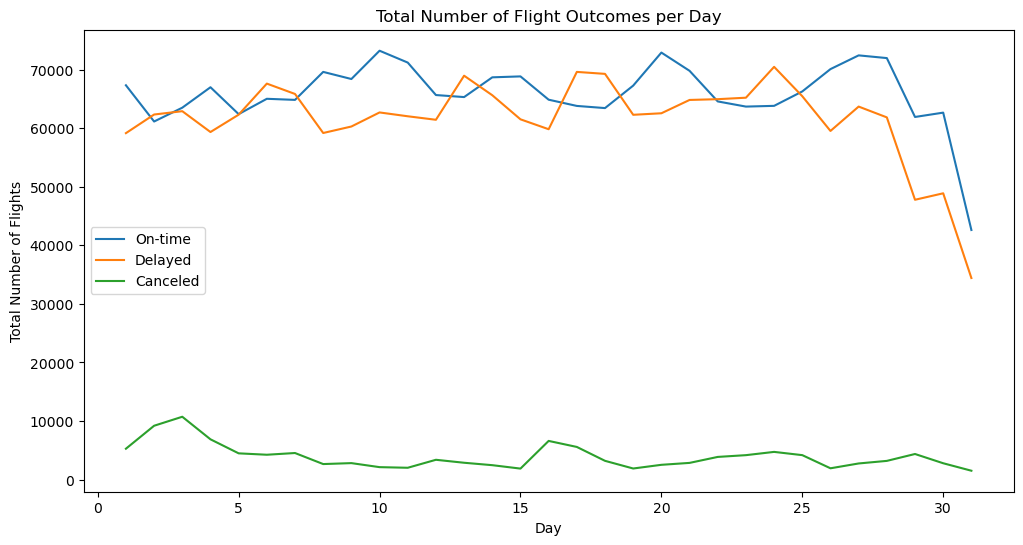

In [34]:
# Plot using Pandas plot.line function
fig, ax = plt.subplots() 
target_by_day.plot.line(figsize=(12,6),
                        title='Total Number of Flight Outcomes per Day',
                        ylabel='Total Number of Flights',
                        ax=ax)
ax.legend(['On-time', 'Delayed', 'Canceled'])

plt.show()